# µSAM - point prompts
Stuart in his third datarelease provided only points for cells.. Lets see what we can do with it

In [1]:
import sys, os; sys.path += ['..']  # NOTE hardcoded project root to find shared util modules

import os
import itertools as it
import json

import numpy as np
import pandas as pd
import skimage
import matplotlib.pyplot as plt

import micro_sam
from micro_sam import instance_segmentation, util

from util.label_studio_converter__brush import mask2rle
from util.plot import *
from util.cache import *

In [2]:
_annot = json.load(open('../data/third/annotations.json'))

def preprocess_point(annot):
  '''
    returns: dict: image → numpy instance segmentation mask
  '''

  out = pd.DataFrame()

  for result in annot[0]['annotations'][0]['result']:
    h,w = result['original_height'], result['original_width']
    # rot = result['image_rotation]

    x = result['value']['x']/100 * w
    y = result['value']['y']/100 * h
    s = result['value']['width']

    i = result['to_name']

    out = pd.concat([out, pd.DataFrame(dict(
      x=[x],
      y=[y],
    ))], ignore_index=True)

  return out

points = preprocess_point(_annot).to_numpy()
_points = points.copy()

In [3]:

dataset_id = 'test'

model_type = 'vit_b'
iou_thresh = 0.88

cache_dir = mk_cache(f"micro-sam/{dataset_id}", dirs='embed masks', clear=True)

In [4]:
imgid = '1-512'

predictor = util.get_sam_model(model_type=model_type)

#pImage = f"../data/{dataset_id}/{imgid}.jpg"
pImage = f"../data/third/1.jpg"
pEmbed = f"{cache_dir}/embed/{imgid}-{model_type}.zarr"

image = skimage.io.imread(pImage)[:512, :512, :] # NOTE: only use a small part of the image for testing

embeddings = util.precompute_image_embeddings(
  predictor, image, ndim = 2, save_path=pEmbed,
  tile_shape=(tile:=1024, tile), halo=(halo:=tile//4, halo)
)

Predict image embeddings for tiles: 100%|███████████████| 1/1 [00:09<00:00,  9.15s/it]

Predict image embeddings for tiles: 100%|███████████████| 1/1 [00:09<00:00,  9.15s/it]

In [5]:

r = 25 # make dummy boxes with this radius around the points

points = np.array([p for p in points[::5] if p[0] < image.shape[0] and p[1] < image.shape[1]])
print("using only every 5th point")

insts_dummybox = [
  micro_sam.prompt_based_segmentation.segment_from_box(
    predictor=predictor,
    image_embeddings=embeddings,
    box=np.array([y-r, x-r, y+r, x+r]),  # NOTE x/y flip!
  )[0] for x,y in points 
]

masks = np.zeros(image.shape[:2], dtype=np.uint16)
for i, inst in enumerate(insts_dummybox):
  masks[inst] = i+1

using only every 5th point


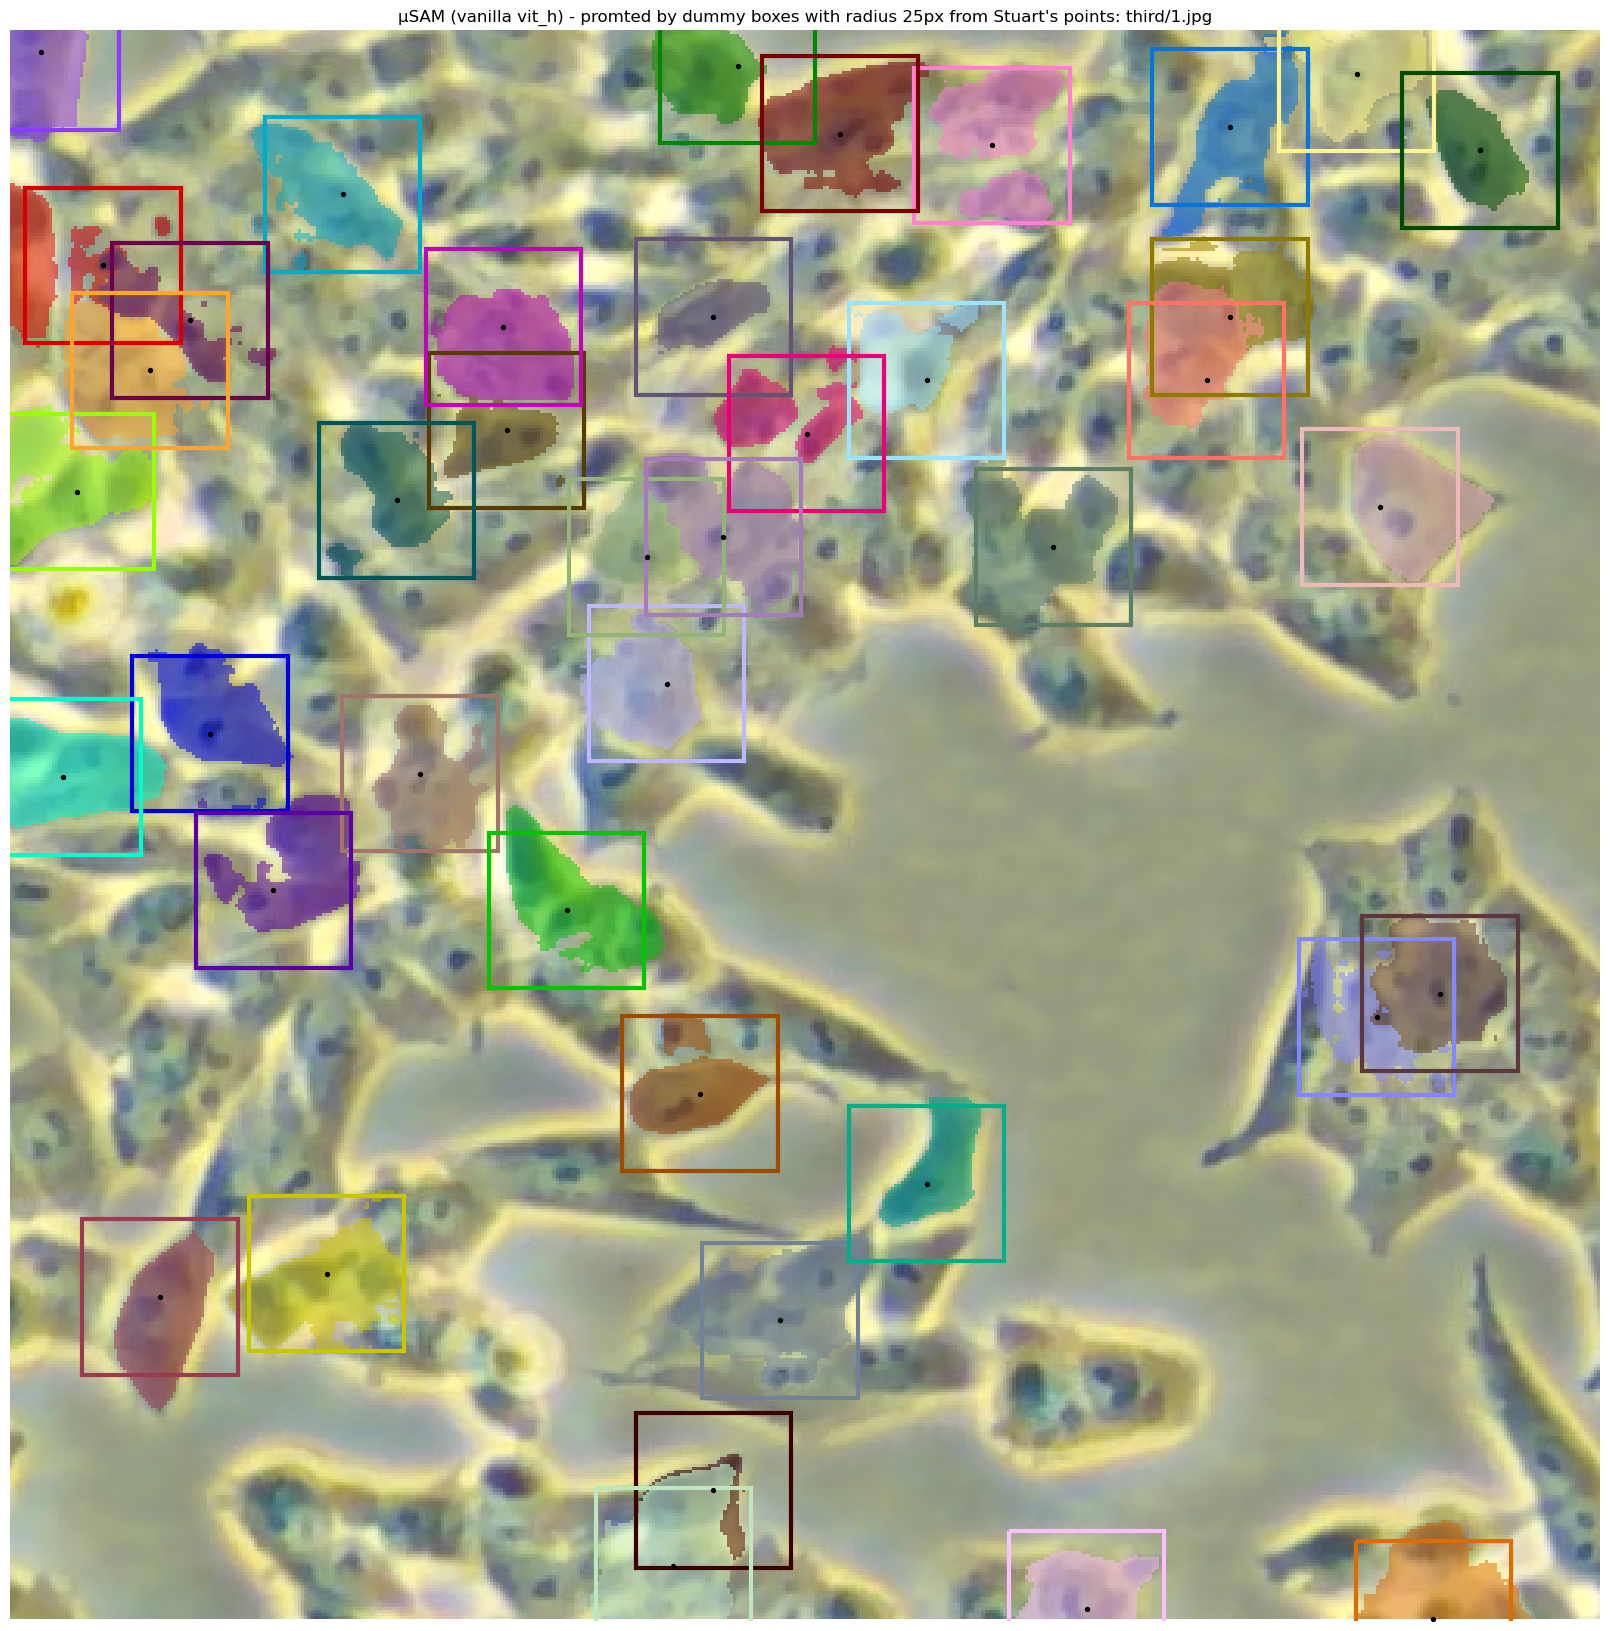

In [6]:

from matplotlib.patches import Rectangle

colors = colorcet.m_glasbey.colors
colors = [c for c, (x,y) in zip(it.cycle(colors), points)]

fig, ax = plt.subplots(1,1, figsize=(22+2, 16.5))
plt.tight_layout()

ax.set_title(f"µSAM (vanilla vit_h) - promted by dummy boxes with radius {r}px from Stuart\'s points: third/1.jpg")
ax.axis('off')

ax.imshow(skimage.color.label2rgb(
  masks, image, saturation=1, bg_color=None, alpha=0.5, colors=colors)
)

for c, (x,y) in zip(colors, points):
  ax.add_patch(Rectangle((x-r, y-r), 2*r, 2*r, color=c, fill=False, linewidth=3))

ax.scatter(points[:,0], points[:,1],
  s=8, c='black', marker='o', linewidths=1)

# set the ax to only plot inside the image shape
ax.set_xlim(0, image.shape[1]);
ax.set_ylim(image.shape[0], 0);

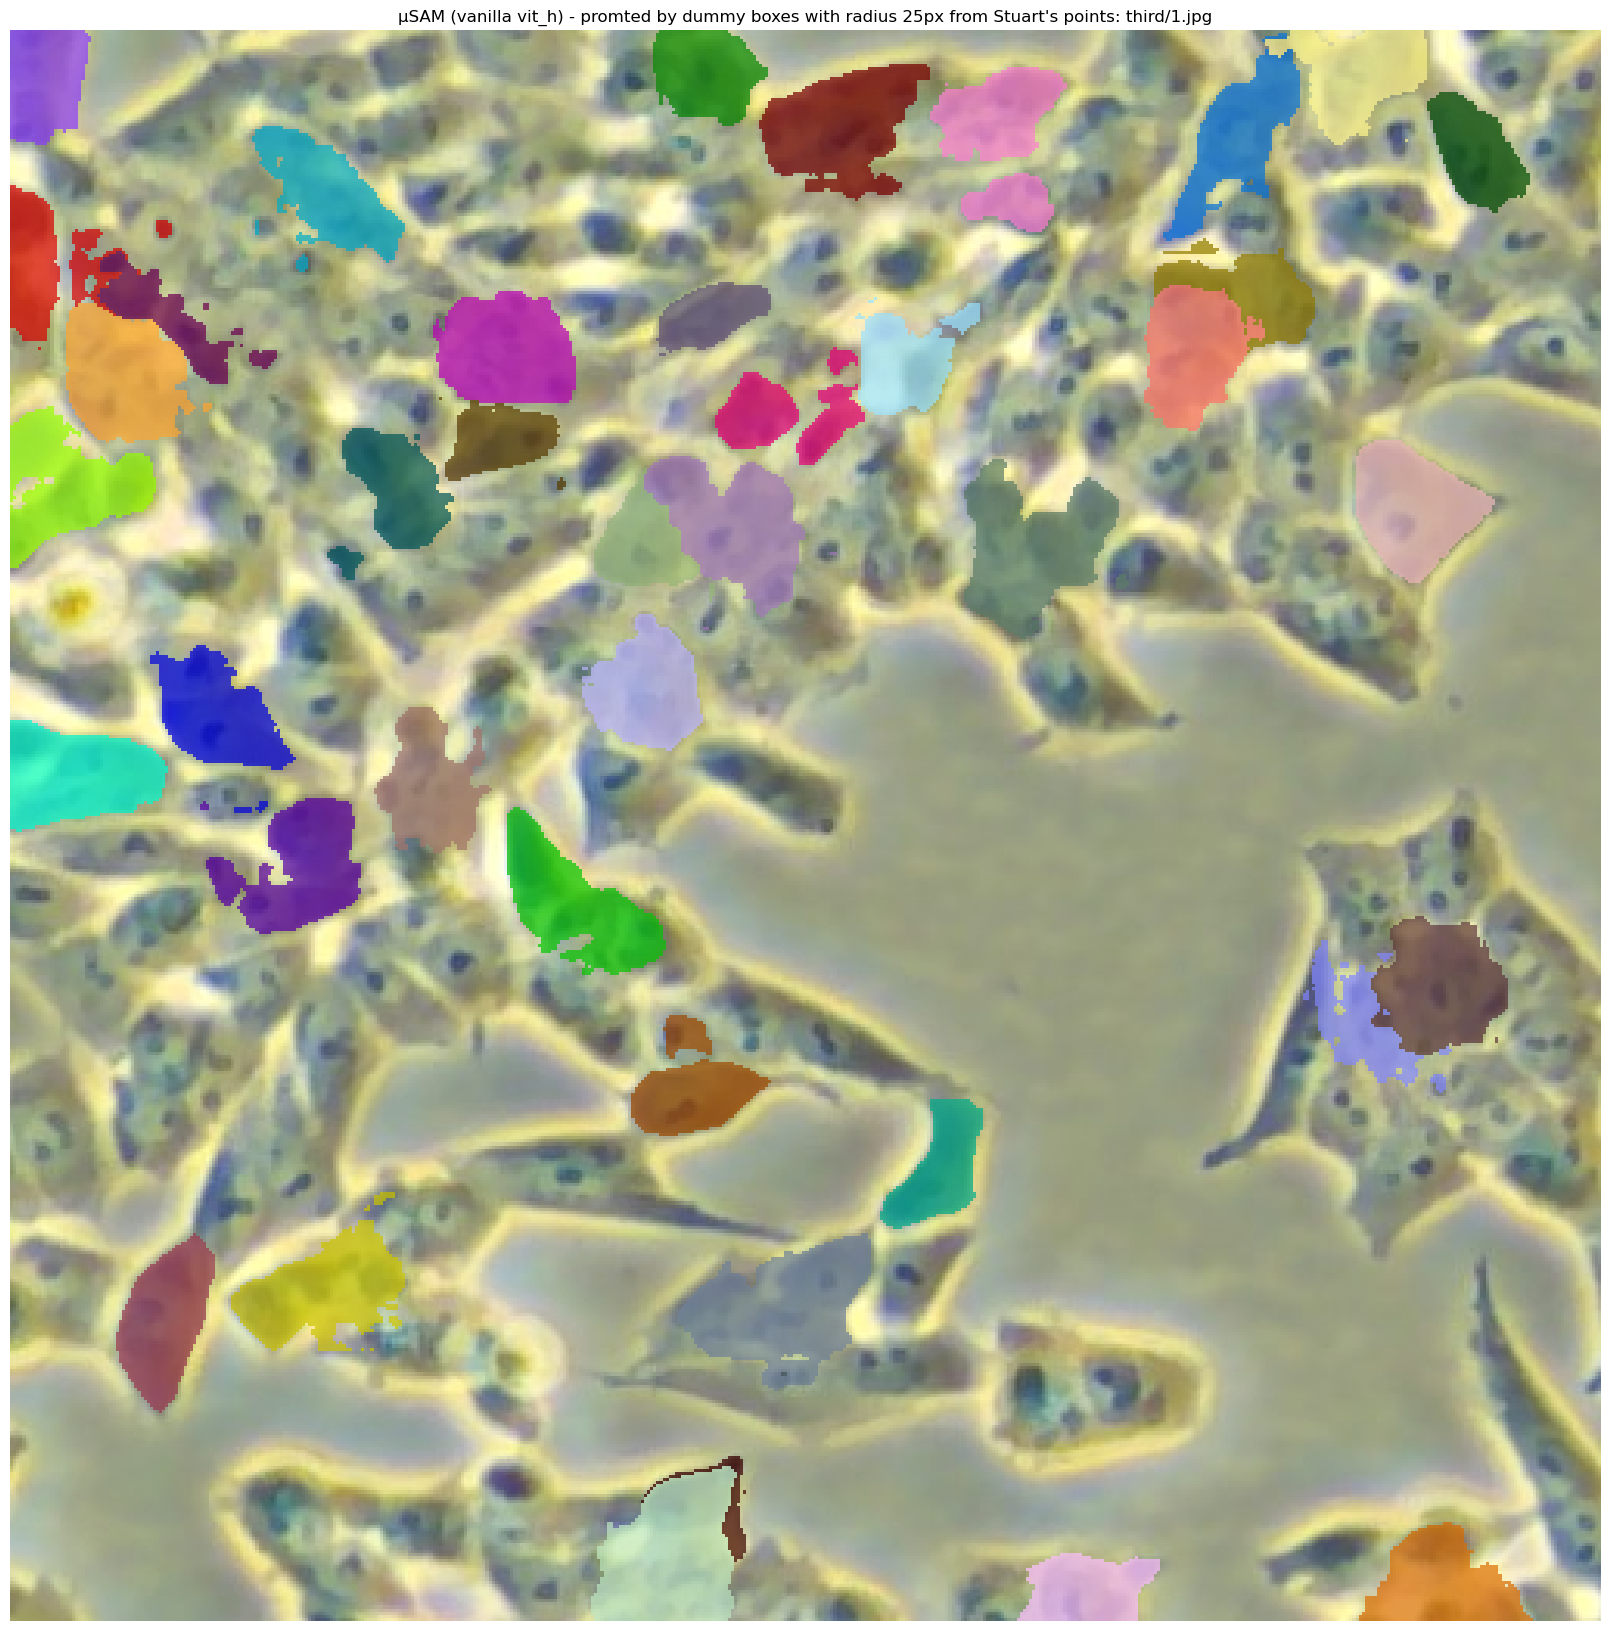

In [7]:

fig, ax = plt.subplots(1,1, figsize=(22+2, 16.5))
plt.tight_layout()

ax.set_title(f"µSAM (vanilla vit_h) - promted by dummy boxes with radius {r}px from Stuart\'s points: third/1.jpg")
ax.axis('off')

ax.imshow(skimage.color.label2rgb(
  masks, image, saturation=1, bg_color=None, alpha=0.7, colors=colors)
)